# General steady-state moment calculation for a two- and three-state promoter.

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [78]:
import os
import pickle
import glob
# Library that we will use to export lambdify functions
import cloudpickle

import itertools # Library we'll use to generate possible pairs of numbers

# Numerical workhorse
import numpy as np
import pandas as pd

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import ccutils

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'
datadir = '../../data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()

# $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{{#1}^{\text{th}}}$
$\newcommand{dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{Km}{\bb{K}}$
$\newcommand{Rm}{\bb{R}_m}$
$\newcommand{Re}{\bb{R}_m'}$
$\newcommand{Gm}{\bb{\Gamma}_m}$
$\newcommand{Rp}{\bb{R}_p}$
$\newcommand{Gp}{\bb{\Gamma}_p}$

## General calculation of the moments of the distribution.

In order to approximate the entire mRNA and protein distribution $P(m, p)$ we use the maximum entropy approach in which moments $\ee{m^x p^y}$ with $x, y \in \mathbb{Z}$ are used to approximate the distribution as
$$
\hat{P}(m, p) = {e^{\sum_{j} \beta_j m^{x_j} p^{y_j}} \over \mathcal{Z}},
$$
where $\beta_j$ is the Lagrange multiplier associated with the $\th{j}$ constraint of the form $\ee{m^{x_j} p^{y_j}}$, and $\mathcal{Z}$ is the partition funciton defined as
$$
\mathcal{Z} = \sum_m \sum_p e^{\sum_{j} \beta_j m^{x_j} p^{y_j}}.
$$

In particular for our system the master equation that describes the time evolution of the distribution is defined by either two or three differential equations, one for each state of the promoter such that
$$
P(m, p) = \sum_{s\in \text{states}} P_s(m, p),
$$
where $s \in \{B, E, R\}$ defines the state $E =$ empty state, $P =$ RNAP bound, and $R =$ repressor bound. The third state is only include in the case where there is transcription factor present. Without loss of generality let's focus here on the three-state promoter. Let $\bb{P}(m, p) = (P_B(m, p), P_E(m, p), P_R(m, p))^T$ be the vector containing all distributions. Using this notation the system of PDEs that define the distribution is given by
$$
\dt{\bb{P}(m, p)} = \overbrace{
\left(\Km - \Rm - m\Gm - m\Rp -p\Gp \right) \bb{P}(m, p)
}^{\text{exit state }m,p}\\
\overbrace{
+ \Rm \bb{P}(m-1, p) + \Gm (m + 1) \bb{P}(m+1, p)\\
+ \Rp (m) \bb{P}(m, p-1) + \Gm (p + 1) \bb{P}(m, p+1)
}^{\text{enter state }m,p},
\label{master_matrix}
$$
where $\Km$ is the matrix defining transition rates between states, $\Rm$ and $\Gm$ are the matrices defining the production and degradation rates of mRNA respectively, and $\Rp$ and $\Gp$ are the equivalent matrices for the production and degradation of protein.

Given this birth-death process with three different states of the promoter if we want to compute a moment $\ee{m^x p^y}$ we would actually compute
$$
\ee{m^x p^y} = \ee{m^x p^y}_E + \ee{m^x p^y}_P + \ee{m^x p^y}_R,
$$
i.e. the moment at each of the states of the promoter. Let 
$\bb{\ee{m^x p^y}} = \left(\ee{m^x p^y}_E, \ee{m^x p^y}_P, \ee{m^x p^y}_R\right)$ be a vector containing all three moments. The moment PDE is then given by
$$
\dt{\bb{\ee{m^x p^y}}} = \sum_m \sum_p \dt{\bb{P}(m,p)}.
$$

This is computed using Eq. \ref{master_matrix} obtaining
$$
\dt{\bb{\ee{m^x p^y}}} = 
\sum_m \sum_p \left(\Km - \Rm - m\Gm - m\Rp -p\Gp \right)m^x p^y \bb{P}(m, p)\\
\overbrace{
+ \Rm \sum_m \sum_p m^x p^y \bb{P}(m-1, p) 
}^{1}
\overbrace{
+ \Gm \sum_m \sum_p (m + 1) m^x p^y \bb{P}(m+1, p)
}^{2}\\
\overbrace{
+ \Rp \sum_m \sum_p (m) m^x p^y \bb{P}(m, p-1) 
}^{3}
\overbrace{
+ \Gm \sum_m \sum_p (p + 1) m^x p^y \bb{P}(m, p+1)
}^{4}.
\label{master_moment_sum}
$$
Each of the numbered terms have stereotypical "tricks" to simplify them. Let's list them (derivation left elsewhere):
$$
1: m' \equiv m - 1\\
\Rightarrow
\sum_m \sum_p m^x p^y \bb{P}(m-1, p) = 
\sum_{m'} \sum_p (m' + 1)^x p^y \bb{P}(m', p) = \\
\bb{\ee{(m+1)^x p^y}},
$$
$$
2: m' \equiv m + 1\\
\Rightarrow
\sum_m \sum_p (m + 1) m^x p^y \bb{P}(m + 1, p) = 
\sum_{m'} \sum_p m' (m' - 1)^x p^y \bb{P}(m', p) = \\
\bb{\ee{m (m - 1)^x p^y}},
$$
$$
3: p' \equiv p - 1\\
\Rightarrow
\sum_m \sum_p (m) m^x p^y \bb{P}(m, p-1) =
\sum_m \sum_{p'} m^{x + 1} (p' + 1)^y \bb{P}(m, p') = \\
\bb{\ee{m^{x + 1} (p +  1)^{y}}},
$$
$$
4: p' \equiv p + 1\\
\Rightarrow
\sum_m \sum_p (p + 1) m^x p^y \bb{P}(m, p+1) =
\sum_m \sum_{p'} p' m^x (p' - 1)^y \bb{P}(m, p') = \\
\bb{\ee{m^x p (p - 1)^y}}.
$$

Given these tricks and Eq. \ref{master_moment_sum} we can write a **general** form for the moment PDE given by
$$
\dt{\bb{\ee{m^x p^y}}} =
\Km \bb{\ee{m^x p^y}} +\\
\Rm \left[ \bb{\ee{(m+1)^x p^y}} - \bb{\ee{m^x p^y}} \right] +\\
\Gm \left[ \bb{\ee{m (m - 1)^x p^y}} - \bb{\ee{m^{x + 1} p^y}} \right] +\\
\Rp \left[ \bb{\ee{m^{x + 1} (p +  1)^{y}}} - \bb{\ee{m^{x+1} p^y}} \right] +\\
\Gp \left[ \bb{\ee{m^x p (p - 1)^y}} - \bb{\ee{m^x p^{y+1}}} \right]
\label{master_moment}
$$

## Using `sympy` to compute moments

The objective of this notebook is to use `sympy` in order to set \ref{master_moment} to steady state and solve the equation for the desired moment $\bb{\ee{m^x p^y}}$. This is going to be a function of all moments $\bb{\ee{m^{x'} p^{y'}}}$ with $x' + y' \leq x + y$. For example for the protein second moment $\bb{\ee{p^2}}$ we would need to know
$$
\bb{\ee{p^2}} = f\left(\bb{\ee{m^0 p^0}}, \bb{\ee{m^1 p^0}}, \bb{\ee{m^2 p^0}},
\bb{\ee{m^0 p^1}}, \bb{\ee{m^1 p^1}}\right).
$$

So all we have to do to compute the $\bb{\ee{m^x p^y}}$ moment is to solve for all the moments that satisfy the $x' + y' \leq x + y$ condition before. It is not as good as an MGF, but it is an effective method of getting at these moments.

### Define general moment equation.

Let's define the `sympy` variables that we will need for Eq. \ref{master_moment}.

In [3]:
# Define the matrices involved in the general moment equation
Km = sympy.Symbol('{\mathbf{K}}')  # State transition matrix
Rm, Gm = sympy.symbols('{\mathbf{R}_m} {\mathbf{\Gamma}_m}')  # mRNA matrices
Rp, Gp = sympy.symbols('{\mathbf{R}_p} {\mathbf{\Gamma}_p}')  # protein matrices

Km, Rm, Gm, Rp, Gp

In [4]:
# Define the mRNA and protein variables
m, p, = sympy.symbols('{\mathbf{m}} {\mathbf{p}}')
x, y = sympy.symbols('{\mathbf{x}} {\mathbf{y}}')

m**x, p**y

Let's now define the right hand side of Eq. \ref{master_moment}.

In [5]:
# Defining the general master moment equation
master_moment = Km * (m**x * p**y) +\
Rm * (p**y) * ((m + 1)**x - m**x) +\
Gm * (m * p**y) * ((m - 1)**x - m**x) +\
Rp * m**(x + 1) * ((p + 1)**y - p**y) +\
Gp * (m**x * p) * ((p - 1)**y - p**y)

sympy.Eq(0, master_moment)

Having defined this equation now all we need to do to obtain any moment equation is to substitute $\bb{x}$ and $\bb{y}$. As a sanity check let's look at some examples that we already know the answer. Let's look at the first mRNA moment.

In [6]:
# Define the first mRNA moment <m> equation
master_moment.subs([[x, 1], [y, 0]]).factor([m, p])

The term with $\Rm$ only is actually $\Rm \bb{m}^0$ which is exactly what one obtains when solving for this particular moment.

Let's look now at the second protein moment.

In [7]:
master_moment.subs([[x, 0], [y, 2]]).factor([m, p])

This is again the answer one gets performing the calculation specifically for this moment.

### Extract coefficients of moment polynomial equation.

Let's now define a function that given an expression for a moment it returns a dictionary with all the coefficients of each of the elements in the equation. For example for the previous example of the second protein moment it should return something of the form
$$
\{
\bb{p}^2 : (\Km - 2\Gm), \;\;
\bb{p} : \Gp, \;\;
\bb{mp} : 2\Rp, \;\;
\bb{m} : \Rp
\}
$$

This will be useful for when we substitute the matrices and vectors to solve the linear system.

In [8]:
def coeff_dictionary(eq):
    '''
    Returns a dictionary with each of the coefficients for a given eqent
    equation.

    Parameter
    ---------
    eq : sympy expression.
        Sympy expression for the eqent equation

    Returns
    -------
    coeff_dict : dictionary.
        Dictionary containing all the coefficients of each of the elements
        in the polynomial eqent equation
    '''
    # Find the degree of the eqent for each of the variables
    if eq.has(m):
        m_degree = sympy.Poly(eq).degree(m)
    else:
        m_degree = 0
    if eq.has(p):
        p_degree = sympy.Poly(eq).degree(p)
    else:
        p_degree = 0
    
    return {m**x * p**y: eq.coeff(m**x * p**y).\
            subs([[m, 0], [p, 0]])
            for x in range(m_degree + 1)
            for y in range(p_degree + 1)}

Let's test the function.

In [9]:
p2_dict = coeff_dictionary(master_moment.subs([[x, 0], [y, 2]]).factor([m, p]))
p2_dict

### Build system of equations

From the dictionary of coefficients we can build the augmented matrix that `sympy` uses to solve linear systems. All we need is to define the matrices $\Km$, $\Rm$, $\Gm$, $\Rp$, and $\Gp$ in terms of their components and vectors for each of the moments.

Let's first define the variables that go into the matrices.

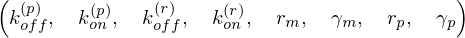

In [10]:
# Define rate constant variables
kp_off, kp_on = sympy.symbols('{k_{off}^{(p)}} {k_{on}^{(p)}}')
kr_off, kr_on = sympy.symbols('{k_{off}^{(r)}} {k_{on}^{(r)}}')

# Define degradation rate and production rate
rm, gm = sympy.symbols('r_m gamma_m')
rp, gp = sympy.symbols('r_p gamma_p')

kp_off, kp_on, kr_off, kr_on, rm, gm, rp, gp

Now let's define a function that given a list of states and a moment of the form $\bb{m^x p^y}$ (as the keys from the dictionary that contains the equation coefficients) it generates an array with the individual moments. For example if the function receives $\bb{m^2 p}$ with three states $\{E, P, R \}$ it returns sympy variables of the form
$$
\ee{m^2 p}_B, \ee{m^2 p}_E, \ee{m^2 p}_R
$$

In [11]:
# Define non-bold variables for m and p
mm, pp = sympy.symbols('m p')
mm, pp

In [12]:
def moment_dict(moments, states=['B', 'E', 'R']):
    '''
    Function that generates automatically sympy variables for a given moment
    one for each of the specified states.
    
    Parameters
    ----------
    moments : list.
        List of sympy variables of the form m**x * p**y for which to 
        generate the moment variables.
    states : array-like. Default = ['B', 'E', 'R']
        List containing strings that define each of the states for which
        to define the moment variables.
        
    Returns
    -------
    moments_dict : dictionary.
        dictionary containing all new defined variables associated with each
        moment.
    '''
    # Initialize dictionary to save the variables
    moments_dict = dict()
    
    # Loop through each of the moments adding the variables to the dictionary
    for mom in moments:
        # Process non-zero moments
        if mom != 1:
            # Find the degree of the moment for each of the variables
            if mom.has(m):
                m_degree = sympy.Poly(mom).degree(m)
            else:
                m_degree = 0
            if mom.has(p):
                p_degree = sympy.Poly(mom).degree(p)
            else:
                p_degree = 0

            # Initialize list to save variables
            mom_var = list()

            # Loop through states to generate the variables
            for s in states:
                mom_var.append(sympy.Symbol('{\\langle ' +
                               sympy.latex(mm**m_degree * pp**p_degree) +
                                            '\\rangle}_' + s))
        else:
            # Initialize list to save variables
            mom_var = list()
            
            # Loop through states to generate the variables
            for s in states:
                mom_var.append(sympy.Symbol('{\\langle m^0 p^0' +
                                            '\\rangle}_' + s))
        # Append variables to dictionary
        moments_dict[mom] = mom_var
        
    return moments_dict

Let's generate a dictionary for the variables in the protein second moment dictionary we saved earlier.

In [13]:
# Extract keys from the p2_dict
p2_keys = [key for key, val in p2_dict.items()]

# Generate dictionary with variables for each variable in dictionary
p2_var_dict = moment_dict(p2_keys)

p2_var_dict

#### Testing system with unregulated promoter.

We now have everything in place to try to solve for moments. As an example case let's try to find the first mRNA moment for the **unregualted two-state promoter**. For this we need first to define the matrices for this case.

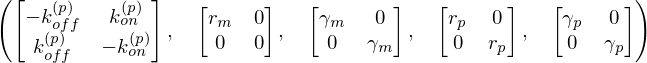

In [14]:
# Define the rate constant matrix
Km_unreg = sympy.Matrix([[-kp_off, kp_on], 
                           [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = sympy.Matrix([[rm, 0], 
                         [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = sympy.Matrix([[gm, 0],
                         [0, gm]])

# Define the protein production matrix
Rp_unreg = sympy.Matrix([[rp, 0], 
                         [0, rp]])
# Define the protein degradation matrix
Gp_unreg = sympy.Matrix([[gp, 0],
                         [0, gp]])


Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg

Now let's find the general equation for this first moment.

In [15]:
# Find the equation for the first moment.
m1_eq = master_moment.subs([[x, 1], [y, 0]]).factor([m, p])

sympy.Eq(0, m1_eq)

Next we extract the coefficients of this equation.

In [16]:
# Extract coefficients from equation
m1_coeff_dict = coeff_dictionary(m1_eq)

m1_coeff_dict

Now we define the moment variables for this system.

In [17]:
# Extract keys from dictionary
m1_keys = [key for key, value in m1_coeff_dict.items()]

# Generate variables for each of the moments
m1_var_dict = moment_dict(m1_keys, states=['B', 'E'])

m1_var_dict

We now define the augmented matrix to solve the linear system.

**NOTE:** on `sympy` getting to substitute a term like $(\Km - \Gm)$ with the corresponding matrices and then actually doing the subtraction is very convoluted. If you want to reproduce this make sure you follow the instructions.

First to simplify things let's generate a dictionary that instead of having the coefficients as `m1_coeff_dict` it has the substituted matrices.

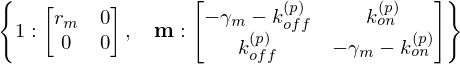

In [18]:
# Initialize dictionary to save the matrices
m1_mat_dict = dict()


tmp_list = list()
# Loop through each of the coefficients and compute the operation
# NOTE: It is quite tricky to get it to work on sympy
for key, value in m1_coeff_dict.items():
    # Extract arguments for the item
    args = value.args
    # Find if any of the arguments is a number
    
    # Check each of the possible cases
    # 1. args is empty and value is zero : 
    # That is a term of the form {key : 0}
    # Generate a matrix of zeros
    if (len(args) == 0) & (value == 0):
        m1_mat_dict[key] = sympy.zeros(*Km_unreg.shape)
   
    # 2. args is empty and value is not zero :
    # That is the case where the term is a single matrix
    # Substitute that value with the actual definition of the matrix
    elif (len(args) == 0) & (value != 0):
        m1_mat_dict[key] = value.subs([[Km, Km_unreg],
                                       [Rm, Rm_unreg],
                                       [Gm, Gm_unreg],
                                       [Rp, Rp_unreg],
                                       [Gp, Gp_unreg]])

    # 3. args is not empty but one of the terms is an integer :
    # That is the case where we have Number * Matrix.
    # substitute the matrix and multiply it by the number
    elif (len(args) != 0) & (any([x.is_Number for x in args])):
        # Substitute value
        term_list = [x.subs([[Km, Km_unreg],
                             [Rm, Rm_unreg],
                             [Gm, Gm_unreg],
                             [Rp, Rp_unreg],
                             [Gp, Gp_unreg]]) for x in value.args]
        # Multiply matrix by constant and register case
        m1_mat_dict[key] = np.prod(term_list)
    
    # 4. args is not empty and non of the elements is an integer :
    # Substitute matrices and reduce to single matrix.
    else:
        term_list = [x.subs([[Km, Km_unreg],
                             [Rm, Rm_unreg],
                             [Gm, Gm_unreg],
                             [Rp, Rp_unreg],
                             [Gp, Gp_unreg]]) for x in value.args]

        # Perform a second round of checking. Elements that have for example
        # Number * Matrix are not explicitly multiplied. For this we will use
        # np.prod by splitting the terms again into its arguments and
        # multiplying the the arguments
        for i, term in enumerate(term_list):
            if len(term.args) == 2:
                term_list[i] = np.prod(term.args)

        # Add the matrices. In order to do so:
        # the sum function has an optional "start" argument so you can 
        # initialize it with a "zero object" of the kind you are adding. 
        # In this case, with a zero matrix.
        m1_mat_dict[key] = sum(term_list, sympy.zeros(*Km_unreg.shape))

m1_mat_dict

After that convoluted substitution we have everything that we need for building the augmented matrix.

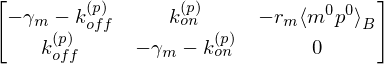

In [19]:
moment = m
# Find the keys for the elements that are not the element we are computing
m1_right_keys = [key for key, value in m1_mat_dict.items() if key != moment]

# Initialize matrix that will be added to the right hand side
m1_right_hand = sympy.zeros(2, 1)

# Loop through each of the keys and add to this matrix
for key in m1_right_keys:
    m1_right_hand = m1_right_hand + m1_mat_dict[key] *\
                                    sympy.Matrix(m1_var_dict[key])

# add columns on the right hand side of minus the rest of the elements
m1_aug_mat = m1_mat_dict[moment].col_insert(2, - m1_right_hand)
m1_aug_mat

Solve the linear system to obtain the first moment!

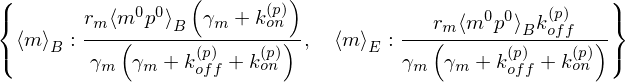

In [20]:
# Solve linear system for the three moments
m1_unreg_dict = sympy.solve_linear_system(m1_aug_mat, *m1_var_dict[m])
m1_unreg_dict

Now we compute the sum of each of the elements to get the global first moment $\ee{m}$

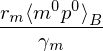

In [21]:
m1_unreg = sum(m1_unreg_dict.values()).simplify()
m1_unreg

This is exactly the expected solution! It seems that the method is working.

#### Defining a function for this computation.

Given the long list of steps in this process let's define a function that given a moment $\ee{m^x p^y}$ goes through the entire process of solving the linear system.

First we define a function that given a dictionary containing all the coefficients for each of the moments it performs the appropriate substitutions and returns a dictionary containing the evaluated matrices. This is a little tricky to do with `sympy` and the function has to go through each of the possible scenarios of the form:
1. {moment : $0$}
2. {moment : $\bb{A}$} with $\bb{A}$ one of the matrices from the CME
3. {moment : $N \bb{A}$} with $N \in \mathbb{Z}$
4. {moment : $(N \bb{A} \pm N' \bb{B})$ with $\bb{A}$ and $\bb{B}$ being matrices and $N, N' \in \mathbb{Z}$

In [22]:
def coeff_subs(coeff_dict, Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat):
    '''

    Parameters
    ----------
    coeff_dict : dictionary.
        Dictionary containing all the coefficients associated with each of the
        moments in the moment equation.
    Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat: 2D sympy matrices.
        Sympy matrices that define the master equation.
        Km_mat : transition between states
        Rm_mat : mRNA produciton
        Gm_mat : mRNA degradation
        Rp_mat : protein production
        Gp_mat : protein degradation

    Returns
    -------
    mom_mat_dict : dictionary.
        Dictionary containing each of the substitutted coefficients into matrices
    '''
    # Initialize dictionary to save the matrices
    mom_mat_dict = dict()

    # Loop through each of the coefficients and compute the operation
    # NOTE: It is quite tricky to get it to work on sympy
    for key, value in coeff_dict.items():
        # Extract arguments for the item
        args = value.args

        # Check each of the possible cases

        # 1. args is empty and value is zero :
        # That is a term of the form {key : 0}
        # Generate a matrix of zeros
        if (len(args) == 0) & (value == 0):
            mom_mat_dict[key] = sympy.zeros(*Km_mat.shape)

        # 2. args is empty and value is not zero :
        # That is the case where the term is a single matrix
        # Substitute that value with the actual definition of the matrix
        elif (len(args) == 0) & (value != 0):
            mom_mat_dict[key] = value.subs([[Km, Km_mat],
                                            [Rm, Rm_mat],
                                            [Gm, Gm_mat],
                                            [Rp, Rp_mat],
                                            [Gp, Gp_mat]])

        # 3. args is not empty but one of the terms is an integer :
        # That is the case where we have Number * Matrix.
        # substitute the matrix and multiply it by the number
        elif (len(args) != 0) & (any([x.is_Number for x in args])):
            # Substitute value
            term_list = [x.subs([[Km, Km_mat],
                                 [Rm, Rm_mat],
                                 [Gm, Gm_mat],
                                 [Rp, Rp_mat],
                                 [Gp, Gp_mat]]) for x in value.args]
            # Multiply matrix by constant and register case
            mom_mat_dict[key] = np.prod(term_list)

        # 4. args is not empty and non of the elements is an integer :
        # Substitute matrices and reduce to single matrix.
        else:
            term_list = [x.subs([[Km, Km_mat],
                                 [Rm, Rm_mat],
                                 [Gm, Gm_mat],
                                 [Rp, Rp_mat],
                                 [Gp, Gp_mat]]) for x in value.args]

            # Perform a second round of checking. Elements that have for example
            # Number * Matrix are not explicitly multiplied. For this we will use
            # np.prod by splitting the terms again into its arguments and
            # multiplying the the arguments
            for i, term in enumerate(term_list):
                if len(term.args) == 2:
                    term_list[i] = np.prod(term.args)

            # Add the matrices. In order to do so:
            # the sum function has an optional "start" argument so you can
            # initialize it with a "zero object" of the kind you are adding.
            # In this case, with a zero matrix.
            mom_mat_dict[key] = sum(term_list, sympy.zeros(*Km_mat.shape))
            
    return mom_mat_dict

Let's test the function generating the dictionary associated with the protein second moment.

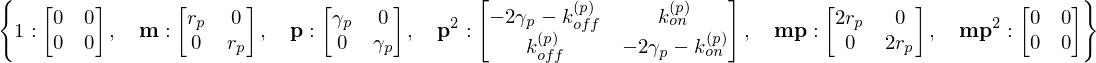

In [23]:
mom_coeff_dict = coeff_dictionary(master_moment.\
                                  subs([[x, 0], [y, 2]]).factor([m, p]))
coeff_subs(mom_coeff_dict, Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg)

Now let's define a function that given a general moment equation, a set of exponents for the desired moments and a lists of matrices and states it solves the system for the desired moment.

In [24]:
def solve_moment(moment_eq, m_expo, p_expo,
                 Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat,
                 states=['B', 'E', 'R']):
    '''
    Function that given a general moment equation and some exponents it solves
    the linear system for m**m_expo * p**p_expo at steady state.
    
    Parameters
    ----------
    moment_eq : sympy expression.
        Sympy equation for the general moment.
    m_expo, p_expo : int.
        Exponent of the moments that should be computed. These moments indicate
        the moment of the form <m**m_expo * p**p_expo> that should be computed.
    Km_mat, Rm_mat, Gm_mat, Rp_mat, Gp_mat: 2D sympy matrices.
        Sympy matrices that define the master equation.
        Km_mat : transition between states
        Rm_mat : mRNA produciton
        Gm_mat : mRNA degradation
        Rp_mat : protein production
        Gp_mat : protein degradation
    states : array-like.
        List of the name of the states that are included in the system.
        
    Returns
    -------
    mom_sol_dict : dictionary.
        Dictionary containing the solution to the linear system for the desired
        moment.
    '''
    # Define sympy variable for moment
    moment = m**m_expo * p**p_expo
    
    # Find the equation for the moment.
    mom_eq = moment_eq.subs([[x, m_expo], [y, p_expo]]).factor([m, p])
    
    # Extract coefficients from equation and save them as a dictionary
    # in which each key is the moment and each value is the coefficient
    # associated with that moment
    mom_coeff_dict = coeff_dictionary(mom_eq)
    
    # Extract keys from dictionary
    mom_keys = [key for key, value in mom_coeff_dict.items()]

    # Generate variables for each of the moments and save them
    # as a dictionary in which each key is the moment and each value
    # is a list of the variables associated with the moment
    mom_var_dict = moment_dict(mom_keys, states=states)
    
    # If asked for the zeroth moment the extendedm matrix is different
    if m_expo + p_expo == 0:
        # Build extended matrix adding extra row for normalization constraint
        # Add the extra row for the normalization constraint
        mom_aug_mat = Km_mat.row_insert(0,
                      sympy.ones(1, Km_mat.shape[0]))

        # Define right-side array
        b = sympy.zeros(mom_aug_mat.shape[0], 1)
        b[0] = 1

        # Define augmented matrix
        mom_aug_mat = mom_aug_mat.col_insert(mom_aug_mat.shape[1], b)
    
        # Solve linear system for the moments
        return sympy.solve_linear_system(mom_aug_mat, *mom_var_dict[moment])
        
    # Obtain dictionary with subsituted matrices for each of the coefficients
    # in the moment equation
    mom_mat_dict = coeff_subs(mom_coeff_dict, Km_mat, Rm_mat, Gm_mat, 
                              Rp_mat, Gp_mat)

    # Find the keys for the elements that are not the element we are computing
    mom_right_keys = [key for key, value in mom_mat_dict.items() if key != moment]

    # Initialize matrix that will be added to the right hand side
    mom_right_hand = sympy.zeros(Km_mat.shape[0], 1)

    # Loop through each of the keys and add to this matrix
    for key in mom_right_keys:
        mom_right_hand = mom_right_hand + mom_mat_dict[key] *\
                                        sympy.Matrix(mom_var_dict[key])

    # add columns on the right hand side of minus the rest of the elements
    mom_aug_mat = mom_mat_dict[moment].col_insert(Km_mat.shape[0], 
                                                  - mom_right_hand)
    
    # Solve linear system for the three moments
    mom_sol_dict = sympy.solve_linear_system(mom_aug_mat, 
                                               *mom_var_dict[moment])
    
    return mom_sol_dict

Let's obtain the first protein moment $\ee{p}$ to check that the function works.

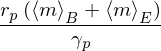

In [25]:
p1_unreg_dict = solve_moment(master_moment, 0, 1,
                           Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg,
                           ['B', 'E'])

sum(p1_unreg_dict.values()).simplify()

This is the right answer!

## Systematically obtain moments as function of rates

Now that we have this function working we can compute up to a desired moment $\ee{m^x p^y}$ by systematically solving the system for all moments $\ee{m^{x'} p^{y'}}$ such that $x' + y' \leq x + y$ and then substituting each solution on the other.

Let's define a function that performs this systematic calculation. For a given mRNA and protein power $x$ and $y$ it finds all possible pairs of exponents that add up to a number less than the sum.

In [26]:
# Define exponents
m_exp, p_exp = 0, 3

# Find possible pairs of exponents
expo_pairs = list(itertools.permutations(range(max([m_exp, p_exp]) + 1), 2))

# Add the (num, num) pair that are not being included
expo_pairs = expo_pairs + [tuple([s, s]) for s in range(max([m_exp, p_exp]))]

# Remove the ones that does not satisfy x' + y' <= x + y
expo_pairs = [x for x in expo_pairs if sum(x) <= m_exp + p_exp]

# Initialize dictionary that will save each of the solutions dictionaries
# That's right, this will be a dictionary with dictionaries as values for each key
mom_sol_dict = {m**x * p**y : solve_moment(master_moment, x, y,
                              Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg,
                              ['B', 'E']) 
               for (x, y) in expo_pairs}

In order to do the substitutions in the proper order we will define a function that sorts the moments as follows:
- Firt all of the mRNA moments $(x, 0)$
- Then each protein moment $(0, y)$ preceded by the cross correlations $(x', y')$ such that $x' + y' = y$

This will allow us to do the systematic substitutions in the correct order to find all the moments purely as as function of the rates in the master equation.

In [27]:
def sort_moments(expo_pairs):
    '''
    Sorts the moments in the right order for the substitutions to be done in the
    proper order
    
    Parameter
    ---------
    expo_pairs : list.
        list of exponents of the moments to be sorted
    
    Returns
    -------
    expo_sorted : list.
        List of exponentes sorted in the right way
    '''
    # Initialize list to append sorted moments
    expo_sorted = list()
    
    # Append mRNA moments
    mRNA_mom = sorted([s for s in expo_pairs if s[1] == 0])
    expo_sorted.append(mRNA_mom)
    
    # Find each protein moment
    protein_mom = sorted([s for s in expo_pairs if (s[0] == 0) & (s[1] != 0)])
    
    # Loop through each protein moment and find the cross correlations
    # associated with it
    for p in protein_mom:
        cross_corr = sorted([s for s in expo_pairs
                             if (s[0] > 0) & (s[1] > 0) & (sum(s) == p[1])],
                            reverse=True)
        # append it to the list
        expo_sorted.append(cross_corr)
        expo_sorted.append([p])
    
    
    return list(itertools.chain.from_iterable(expo_sorted))

Now we can perform the systematic substitution of the solutions!
It is a tricky convoluted system. Not very pretty, but effective.

In [28]:
# Extract all variables involved in the solutions
keys = [key for key in mom_sol_dict.keys()]
mom_vars = [value for key, value  in moment_dict(keys).items()]
mom_vars = list(itertools.chain.from_iterable(mom_vars))

# Initialize array with substituted solutions. For this we only need to
# start with the zeroth moment
mom_sol_subs_dict = mom_sol_dict[1].copy()

# Sort the exponents to perform the substitutions in the right order
expo_sorted = sort_moments(expo_pairs)

# Loop through each of the moments substituting the solution of the previous one
for m_exp, p_exp in expo_sorted[1:]:
    print(m_exp, p_exp)
    # Extract moment to be substituted
    sub_mom = mom_sol_dict[m**m_exp * p**p_exp].copy()
    
    # Loop through each of the elements of this moment
    for mom_raw, sol_raw in sub_mom.items():
        # Find all variables involved in this solution
        symbols = list(set(list(sol_raw.free_symbols)))
        
        # Keep only the moment variables to be substituted
        var_subs = [s for s in symbols if s in mom_vars]
        
        # Initialize dictionary to save all substituted variables
        sub_dict = dict()
        # Loop through these variables substitutting them
        for var in var_subs:
            sub_dict[var] = mom_sol_subs_dict[var]
            
        # Substitute all variables
        sub_mom[mom_raw] = sub_mom[mom_raw].subs(sub_dict)
    
        # Add substituted solution to dictionary
        mom_sol_subs_dict[mom_raw] = sub_mom[mom_raw]

1 0
2 0
3 0
0 1
1 1
0 2
2 1
1 2
0 3


### Generate `lambdify` functions.

Having computed the solutions purely as function of the rates we now can generate the `lambdify` functions that will allow us to evaluate these moments numerically.

In order to make this effective we will generate a dictionary where the `key` will be a pair of exponents $(x, y)$ and the `value` will be will be the `lambidfy` function for the global moment.

First let's collect the global moments by adding the individual promoter state moments.

In [29]:
# Extract the moments
moments = [key for key in mom_sol_dict.keys()]

# Generate the dictionary with all the variables
mom_var_dict = moment_dict(moments, states=['B', 'E'])

# Initialize dictionary to save global moments
mom_global = {}

# Loop through each of the moments, extract the solution for each of the
# moments and add them to obtain the global moment
for key, value in mom_var_dict.items():
    # Extract the solutions for each individual moment and add them
    mom_global[key] = sum([mom_sol_subs_dict[s] for s in value])

Let's confirm that all the substitutions were done correctly by checking the `free_symbols` for each of the global moments.

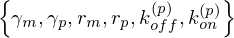

In [30]:
# Initialize list to save variables on each moment
mom_global_var = list()

# Loop trhough each moment and extract the free symbols
for key, value in mom_global.items():
    mom_global_var.append(list(value.free_symbols))

# Find the unique variables
unique_sym = set([item for sublist in mom_global_var for item in sublist])
unique_sym

Not a single moment variable $\ee{m^x p^y}$. Therefore the systematic substitution worked as expected.

Having the global moments now let's generate the `lambdify` functions and store them in a dictionary where the keys will not be the `sympy` variables for the moment since this dictionary will be saved and imported in other notebooks. Instead the key will be a tuple of the form $(x, y)$.

In [31]:
# Define array containing variables
var = [kp_on, kp_off, rm, gm, rp, gp]

# Initialize dictionary to save lambdify functions
mom_global_lambdify = {}

# Loop through every global moment
for key, value in mom_global.items():
    # Find the exponents of the moment
    if key.has(m):
        m_degree = sympy.Poly(key).degree(m)
    else:
        m_degree = 0
    if key.has(p):
        p_degree = sympy.Poly(key).degree(p)
    else:
        p_degree = 0
    print((m_degree, p_degree))
    
    # Generate and save into the dictionary the lambdify function.
    mom_global_lambdify[(m_degree, p_degree)] = sympy.lambdify(var, value, 
                                                               modules='numexpr')

(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 2)
(2, 0)
(2, 1)
(3, 0)
(0, 0)
(1, 1)


In [32]:
export = True
if export:
    # Open file to save functions
    with open('./two_state_moments_lambdify.dill', 'wb') as file:
        cloudpickle.dump(mom_global_lambdify, file)

## Repeat calculation for three-state promoter.

Having obtained up to the fourth protein moment for the unregulated case let's now proceed to the regulated one where we will repeat the same analysis defining the corresponding matrices.

Let's first define the corresponding matrices.

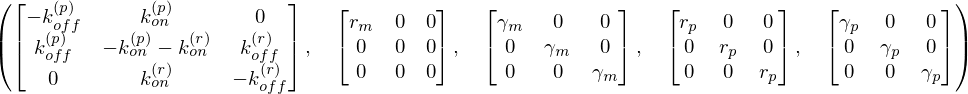

In [33]:
# Define the rate constant matrix
Km_reg = sympy.Matrix([[-kp_off, kp_on, 0], 
                         [kp_off, -(kp_on + kr_on), kr_off],
                         [0, kr_on, -kr_off]])
# Define the production matrix
Rm_reg = sympy.Matrix([[rm, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])
# Define the degradation matrix
Gm_reg = sympy.Matrix([[gm, 0, 0],
                       [0, gm, 0],
                       [0, 0, gm]])

# Define the production matrix
Rp_reg = sympy.Matrix([[rp, 0, 0],
                       [0, rp, 0],
                       [0, 0, rp]])

# Define the production matrix
Gp_reg = sympy.Matrix([[gp, 0, 0],
                       [0, gp, 0],
                       [0, 0, gp]])


Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg

Now we compute the moments for this three-state case adding the `R` state.

In [34]:
# Define exponents
m_exp, p_exp = 0, 3

# Find possible pairs of exponents
expo_pairs = list(itertools.permutations(range(max([m_exp, p_exp]) + 1), 2))

# Add the (num, num) pair that are not being included
expo_pairs = expo_pairs + [tuple([s, s]) for s in range(max([m_exp, p_exp]))]

# Remove the ones that does not satisfy x' + y' <= x + y
expo_pairs = [x for x in expo_pairs if sum(x) <= m_exp + p_exp]

# Initialize dictionary that will save each of the solutions dictionaries
# That's right, this will be a dictionary with dictionaries as values for each key
mom_sol_dict = {m**x * p**y : solve_moment(master_moment, x, y,
                              Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg,
                              ['B', 'E', 'R']) 
               for (x, y) in expo_pairs}

Now the systematic substitutions to generate the moments as function of the rates.

In [35]:
# Extract all variables involved in the solutionsk
keys = [key for key in mom_sol_dict.keys()]
mom_vars = [value for key, value  in moment_dict(keys).items()]
mom_vars = list(itertools.chain.from_iterable(mom_vars))

# Initialize array with substituted solutions. For this we only need to
# start with the zeroth moment
mom_sol_subs_dict = mom_sol_dict[1].copy()

# Sort the exponents to perform the substitutions in the right order
expo_sorted = sort_moments(expo_pairs)

# Loop through each of the moments substituting the solution of the previous one
for m_exp, p_exp in expo_sorted[1:]:
    print(m_exp, p_exp)
    # Extract moment to be substituted
    sub_mom = mom_sol_dict[m**m_exp * p**p_exp].copy()
    
    # Loop through each of the elements of this moment
    for mom_raw, sol_raw in sub_mom.items():
        # Find all variables involved in this solution
        symbols = list(set(list(sol_raw.free_symbols)))
        
        # Keep only the moment variables to be substituted
        var_subs = [s for s in symbols if s in mom_vars]
        
        # Initialize dictionary to save all substituted variables
        sub_dict = dict()
        # Loop through these variables substitutting them
        for var in var_subs:
            sub_dict[var] = mom_sol_subs_dict[var]
            
        # Substitute all variables
        sub_mom[mom_raw] = sub_mom[mom_raw].subs(sub_dict)
    
        # Add substituted solution to dictionary
        mom_sol_subs_dict[mom_raw] = sub_mom[mom_raw]

1 0
2 0
3 0
0 1
1 1
0 2
2 1
1 2
0 3


Let's generate the global moments by adding the moments from each individual promoter state.

In [36]:
# Extract the moments
moments = [key for key in mom_sol_dict.keys()]

# Generate the dictionary with all the variables
mom_var_dict = moment_dict(moments, states=['B', 'E', 'R'])

# Initialize dictionary to save global moments
mom_global = {}

# Loop through each of the moments, extract the solution for each of the
# moments and add them to obtain the global moment
for key, value in mom_var_dict.items():
    # Extract the solutions for each individual moment and add them
    mom_global[key] = sum([mom_sol_subs_dict[s] for s in value])

Again we check that all the moment variables were correctly substituted by listing the unique variables found in the moments.

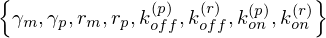

In [37]:
# Initialize list to save variables on each moment
mom_global_var = list()

# Loop trhough each moment and extract the free symbols
for key, value in mom_sol_subs_dict.items():
    mom_global_var.append(list(value.free_symbols))

# Find the unique variables
unique_sym = set([item for sublist in mom_global_var for item in sublist])
unique_sym

And finally generate the `lambdify` expressions for each of these moments.

In [38]:
# Define array containing variables
var = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp]

# Initialize dictionary to save lambdify functions
mom_global_lambdify = {}

# Loop through every global moment
for key, value in mom_global.items():
    # Find the exponents of the moment
    if key.has(m):
        m_degree = sympy.Poly(key).degree(m)
    else:
        m_degree = 0
    if key.has(p):
        p_degree = sympy.Poly(key).degree(p)
    else:
        p_degree = 0
    print((m_degree, p_degree))
    
    # Generate and save into the dictionary the lambdify function.
    mom_global_lambdify[(m_degree, p_degree)] = sympy.lambdify(var, value, 
                                                               modules='numexpr')

(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 2)
(2, 0)
(2, 1)
(3, 0)
(0, 0)
(1, 1)


In [39]:
export = True
if export:
    # Open file to save functions
    with open('./three_state_moments_lambdify.dill', 'wb') as file:
        cloudpickle.dump(mom_global_lambdify, file)

# Numerical evaluation of the moments

### Import `lambdify` functions using `cloudpickle`.

When the analytical results were derived above we generated `lambdify` functions to explore these results numerically and export them into a file using the `cloudpickle` library. Let's now import these functions into not to repeat the calculation again.

In [43]:
# Unregulated two-state promoter
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm, rp, gp)
with open('./two_state_moments_lambdify.dill', 'rb') as file:
    mom_unreg_dict = cloudpickle.load(file)
    
# Regulated three-state promoter
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)
with open('./three_state_moments_lambdify.dill', 'rb') as file:
    mom_reg_dict = cloudpickle.load(file)

## Computing the fold-change in gene expression.

Once we have the functions to compute the moments for the unregulated and regulated promoter at steady-state let's evaluate these functions using the parameters inferred from the different data sets.

First let's import the RNAP rates as well as the transcription rate as obtained from the MCMC fit to the single-molecule FISH data.

In [42]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

# Define protein production and degradation rates
gp = 1 / (60 * 100) # sec^-1
rp = 1000 * gp # sec^-1

For the regulated promoter we need a couple other parameters related to the repressor rates. Let's define them

In [44]:
# Define repressor specific parameters

# Diffusion limited rate
ko = 2.7E-3 # s**-1 nmol**-1

# Number of non-specific binding sites in thermodynamic model
Nns = 4.6E6

# Cell volume
Vcell = 2.15 # fL

# MWC induction parameters
ka = 139 # µM
ki = 0.53 # µM
epsilon = 4.5 # kBT

Fisrt we need to compute the mean mRNA $\ee{m}$ and mean protein copy number $\ee{p}$ for an unregualted promoter. This is necessary to compute the fold-change in gene expression.

In [46]:
# Collect parameters into a single array to feed to the function
par_unreg = [kp_on, kp_off, rm, gm, rp, gp]

# Compute mean mRNA and mean protein copy number
m_mean_unreg = mom_unreg_dict[(1, 0)](*par_unreg)
p_mean_unreg = mom_unreg_dict[(0, 1)](*par_unreg)

print('unregulated promoter:')
print('<m> = {:.2f}'.format(m_mean_unreg))
print('<p> = {:.2f}'.format(p_mean_unreg))

unregulated promoter:
<m> = 18.72
<p> = 18720.04


### Computing the regulated promoter mean mRNA $\ee{m}$ and mean protein $\ee{p}$

Let's now define the range of inducer concentrations, repressor copy numbers and binding energies for which to compute the mean mRNA and protein copy number

In [53]:
# Define experimental concentrations in µM
inducer = np.logspace(-1, np.log10(5000), 49) # µM
inducer = np.insert(inducer, 0, 0)

# Define repressor copy numebers
repressors = [22, 260, 1740]

# Define operators and energies
operators = ['O1', 'O2', 'O3']
energies = [-15.3, -13.9, -9.7]
op_dict = dict(zip(operators, energies))

# Generate list of all operator, repressor and inducer concentrations
var =  [t for t in itertools.product(*[operators, repressors, inducer])]

Let's loop through the parameter combinations and compute the mean mRNA and mean protein copy number

In [54]:
# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM', 
         'm1p0', 'm0p1', 'm_fold_change', 'p_fold_change']

# Initialize DataFrame to save constraints
df_constraints = pd.DataFrame([], columns=names)

# Define function for parallel computation
for i, param in  enumerate(var):
    # Extract variables
    op = param[0]  #operator
    eRA = op_dict[op]  # binding energy
    rep = param[1]  # repressors
    iptg = param[2]  # inducer

    # Calculate the repressor on rate including the MWC model
    kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

    # Compute the repressor off-rate based on the on-rate and 
    # the binding energy
    kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                  Nns, Vcell)
    
    # Collect parameters into a single array to feed to the function
    par_reg = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp]
    
    # Compute mean mRNA and mean protein copy number
    m_mean_reg = mom_reg_dict[(1, 0)](*par_reg)
    p_mean_reg = mom_reg_dict[(0, 1)](*par_reg)
    
    # compute the fold-change
    m_fold_change = m_mean_reg / m_mean_unreg
    p_fold_change = p_mean_reg / p_mean_unreg
    
    # Save results into series in order to append it to data frame
    s = pd.Series([op, eRA, rep, iptg, m_mean_reg, p_mean_reg,
                   m_fold_change, p_fold_change],
                   index=names)
    
    # Append result
    df_constraints = df_constraints.append(s, ignore_index=True)
    
df_constraints.head()

,operator,binding_energy,repressor,inducer_uM,m1p0,m0p1,m_fold_change,p_fold_change
0,O1,-15.3,22,0.000000,0.6679973327404212,667.9973327404227,0.035684,0.035684
1,O1,-15.3,22,0.100000,0.6709051453574878,670.9051453574878,0.035839,0.035839
2,O1,-15.3,22,0.125284,0.6717185141569686,671.7185141569682,0.035882,0.035882
3,O1,-15.3,22,0.156961,0.6727819296889731,672.7819296889728,0.035939,0.035939
4,O1,-15.3,22,0.196646,0.6741837787610292,674.1837787610278,0.036014,0.036014


Let's now plot this fold-change at the protein level for the different repressor copy numbers and repressor-DNA binding energies.

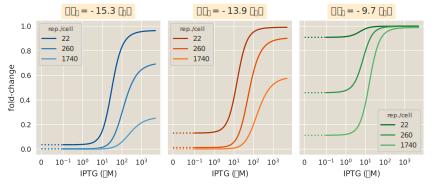

In [66]:
df_group = df_constraints.sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Define energies to go along operators
energies = [-15.3, -13.9, -9.7]

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(repressors, sns.color_palette(col_list[i],
                                        n_colors=len(repressors) + 3)[0:3]))

# Define threshold to separate linear from logarithmic scale
thresh = 1E-1

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), sharex=True, sharey=True)

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                              data[data.inducer_uM >= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    # linear scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                              data[data.inducer_uM <= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')

for i, a in enumerate(ax):
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=thresh, linscalex=1)
#     ax[i].set_ylim(top=1.05)
    # Set legend
    leg = ax[i].legend(title='rep./cell', fontsize=7, loc=0)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=6)
 
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i].set_xlabel(r'IPTG ($\mu$M)')
ax[0].set_ylabel(r'fold-change')

# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

plt.savefig(figdir + 'fold_change_single.pdf', bbox_inches='tight')
plt.savefig(figdir + 'fold_change_single.svg', bbox_inches='tight')

## Computing the noise in gene expression.

Let's now look at the noise defined as
$$
\text{noise} \equiv {\text{STD}(X) \over \ee{X}},
$$
where $\text{STD}(x)$ is the standard deviation of the random variable $X$. The reason for choosing this metric over the commonly used Fano factor is that when quantified from experimental data this is a dimensionless quantity that can be directly inferred from arbitrary units of fluorescence as long as there is a linear relationship between these arbitrary units and the absolute molecule count.

In [79]:
# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM', 
         'm1p0', 'm0p1', 'm2p0', 'm0p2',
         'm_fold_change', 'p_fold_change', 
         'm_noise', 'p_noise']

# Initialize DataFrame to save constraints
df_constraints = pd.DataFrame([], columns=names)

# Define function for parallel computation
for i, param in  enumerate(var):
    # Extract variables
    op = param[0]  #operator
    eRA = op_dict[op]  # binding energy
    rep = param[1]  # repressors
    iptg = param[2]  # inducer

    # Calculate the repressor on rate including the MWC model
    kr_on = ko * rep * ccutils.model.p_act(iptg, ka, ki, epsilon) 

    # Compute the repressor off-rate based on the on-rate and 
    # the binding energy
    kr_off = ccutils.model.kr_off_fun(eRA, ko, kp_on, kp_off,
                                  Nns, Vcell)
    
    # Collect parameters into a single array to feed to the function
    par_reg = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp]
    
    # Compute mean mRNA and mean protein copy number
    m_mean_reg = mom_reg_dict[(1, 0)](*par_reg)
    p_mean_reg = mom_reg_dict[(0, 1)](*par_reg)
    # compute the fold-change
    m_fold_change = m_mean_reg / m_mean_unreg
    p_fold_change = p_mean_reg / p_mean_unreg
    
    # Compute mean mRNA and mean protein second number
    m_second_reg = mom_reg_dict[(2, 0)](*par_reg)
    p_second_reg = mom_reg_dict[(0, 2)](*par_reg)
    # Compute the noise
    m_noise = np.sqrt(m_second_reg - m_mean_reg**2) / m_mean_reg
    p_noise = np.sqrt(p_second_reg - p_mean_reg**2) / p_mean_reg
    
    # Save results into series in order to append it to data frame
    s = pd.Series([op, eRA, rep, iptg, m_mean_reg, p_mean_reg,
                   m_second_reg, p_second_reg,
                   m_fold_change, p_fold_change,
                   m_noise, p_noise],
                   index=names)
    
    # Append result
    df_constraints = df_constraints.append(s, ignore_index=True)
    
# Save data frame into memory
df_constraints.to_csv(datadir + 'single_prom_moments.csv')
df_constraints.head()

,operator,binding_energy,repressor,inducer_uM,m1p0,m0p1,m2p0,m0p2,m_fold_change,p_fold_change,m_noise,p_noise
0,O1,-15.3,22,0.000000,0.6679973327404212,667.9973327404227,5.507835575589098,606272.2549045939,0.035684,0.035684,3.367983,0.598902
1,O1,-15.3,22,0.100000,0.6709051453574878,670.9051453574878,5.537716046578762,611020.7171651486,0.035839,0.035839,3.361983,0.597897
2,O1,-15.3,22,0.125284,0.6717185141569686,671.7185141569682,5.546082413931279,612352.2120479703,0.035882,0.035882,3.360311,0.597617
3,O1,-15.3,22,0.156961,0.6727819296889731,672.7819296889728,5.557026214502752,614095.1877619822,0.035939,0.035939,3.358131,0.597252
4,O1,-15.3,22,0.196646,0.6741837787610292,674.1837787610278,5.571462302801324,616396.5930051125,0.036014,0.036014,3.355265,0.596772


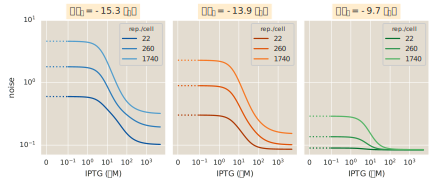

In [80]:
df_group = df_constraints.sort_values('inducer_uM').\
                  groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Define energies to go along operators
energies = [-15.3, -13.9, -9.7]

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(repressors, sns.color_palette(col_list[i],
                                        n_colors=len(repressors) + 3)[0:3]))

# Define threshold to separate linear from logarithmic scale
thresh = 1E-1

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), sharex=True, sharey=True)

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                              data[data.inducer_uM >= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    # linear scale
    ax[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                              data[data.inducer_uM <= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')

for i, a in enumerate(ax):
    # systematically change axis for all subplots
    ax[i].set_xscale('symlog', linthreshx=thresh, linscalex=1)
    ax[i].set_yscale('log')
    # Set legend
    leg = ax[i].legend(title='rep./cell', fontsize=7, loc=0)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=6)
 
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor='#ffedce'))
    # Label axis
    ax[i].set_xlabel(r'IPTG ($\mu$M)')
ax[0].set_ylabel(r'noise')
ax[0].set_ylim(top=1E1)

# Change spacing between plots
plt.subplots_adjust(wspace=0.05)

plt.savefig(figdir + 'noise_single.pdf', bbox_inches='tight')
plt.savefig(figdir + 'noise_single.svg', bbox_inches='tight')

## Comparison with experimental data

In order to assess if our kinetic framework for the moments works we will compare experimentally determined moments to our theoretical predictions.

For this we need to read the microscopy data gathered so far.

In [71]:
# Read the tidy-data frame
files = glob.glob('../../data/csv_microscopy/*IPTG*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)

##  Remove data sets that are ignored because of problems with the data quality
##  NOTE: These data sets are kept in the repository for transparency, but they
##  failed at one of our quality criteria
##  (see README.txt file in microscopy folder)
ignore_files = [x for x in os.listdir('../image_analysis/ignore_datasets/')
                if 'microscopy' in x]
# Extract data from these files
ignore_dates = [int(x.split('_')[0]) for x in ignore_files]

# Remove these dates
df_micro = df_micro[~df_micro['date'].isin(ignore_dates)]

df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'intensity']].head()

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,date,operator,rbs,mean_intensity,intensity
0,20181018,O2,auto,88.876915,502.830035
1,20181018,O2,auto,99.759342,393.291230
2,20181018,O2,auto,94.213193,552.315421
3,20181018,O2,auto,92.993102,426.131591
4,20181018,O2,auto,94.591855,455.251678


Consider that the noise is defined as
\begin{equation}
\text{noise} \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle}.
\end{equation}
Assume that the intensity level of a cell $I$ is linearly proportional to the absolute protein count, i.e.
$$
I = \alpha p,
$$
where $\alpha$ is the proportionality constant between arbitrary units (a.u.) and protein count. Substituting this definition on the noise gives
\begin{equation}
\text{noise} = {\sqrt{\left\langle (\alpha I)^2 \right\rangle - 
                   \left\langle \alpha I \right\rangle^2} \over 
                   \left\langle \alpha I \right\rangle}.
\end{equation}
Since $\alpha$ is a constant it can be taken out of the average operator $\ee{\cdot}$, obtaining
\begin{equation}
\text{noise} = {\sqrt{\alpha^2 \left(\left\langle I^2 \right\rangle - 
              \left\langle I \right\rangle^2 \right)} \over 
              \alpha \left\langle  I \right\rangle}
     = {\sqrt{\left(\left\langle I^2 \right\rangle - 
              \left\langle I \right\rangle^2 \right)} \over 
              \left\langle  I \right\rangle}
\end{equation}

The proportionality between intensity and protein count has no intercept. This ignores the autofluorescence that cells without
reporter would generate. Therefore in practice to compute the noise from experimental intensity measurements we compute
\begin{equation}
\text{noise} = \frac{\sqrt{\left\langle (I  - \langle I_{\text{auto}}\rangle)^2 \right\rangle - \left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle^2}}{\left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle},
\end{equation}
where $I$ is the intensity of the objective strain and $\langle I_{\text{auto}}\rangle$ is the mean autofluorescence intensity.

Having shown that this quantity is dimensionless we can therefore compare the experimentally determined noise with our theoretical predictions. Let's compute both the noise and the fold-change for the regulated promoter.

In [82]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Define names for columns of data frame
names = ['date', 'IPTG_uM','operator', 'binding_energy',
         'rbs', 'repressors', 'mean', 'std', 'noise', 'fold_change']
# Initialize data frame to save the noise
df_noise = pd.DataFrame(columns=names)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].intensity.mean()
    
    # Extract the mean ∆lacI fluorescence
    I_delta = data[data.rbs == 'delta'].intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Obtain the unregulated mean expression to compute
    # the fold-change
    mean_delta = I_delta - I_auto
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.intensity - I_auto).mean(), 
                      (data_inducer.intensity - I_auto).std(ddof=1)]
        # Check if the values are negative for very small noise
        if strain_info[int(np.where(np.array(names) == 'mean')[0])] > 0:
            # Compute the noise
            strain_info.append(strain_info[-1] / strain_info[-2])
            # Compute fold-change
            strain_info.append(strain_info[
            int(np.where(np.array(names) == 'mean')[0])] / mean_delta)
            # Convert to a pandas series to attach to the dataframe
            strain_info = pd.Series(strain_info, index=names)
            # Append to the info to the data frame
            df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise = df_noise.sort_values('repressors')
df_noise.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise,fold_change
79,20180411,250.0,O1,-15.3,HG104,22,11610.123383,4958.182615,0.427057,1.032347
88,20180412,50.0,O1,-15.3,HG104,22,6967.220383,3258.086385,0.467631,0.529563
87,20180412,25.0,O1,-15.3,HG104,22,6103.505644,3462.361282,0.567274,0.463914
86,20180412,10.0,O1,-15.3,HG104,22,2537.301906,1672.347015,0.659104,0.192855
85,20180412,5.0,O1,-15.3,HG104,22,1002.920580,1023.894658,1.020913,0.076230


Let's now plot both the fold-change and the noise.

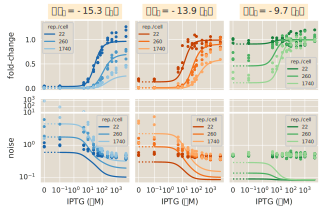

In [85]:
# Define repressor copy numbers to include
rep = df_noise['repressors'].unique()

# Group moments by operator and repressor 
df_group_exp = df_noise[(df_noise.noise > 0)].sort_values('IPTG_uM').\
               groupby(['operator', 'repressors'])
df_group = df_constraints[df_constraints['repressor'].isin(rep)].\
           sort_values('inducer_uM').\
           groupby(['operator', 'repressor'])

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(zip(rep, sns.color_palette(col_list[i], n_colors=len(rep) + 1)[0:3]))

# Set threshold to separate linear and logarithmic scale    
thresh = 1E-1

fig = plt.figure(figsize=(5, 3))
# Define outer grispec to keep at top the fold-change and at the bottom
# the noise
gs_out = mpl.gridspec.GridSpec(2, 1, height_ratios = [1, 1 + 1/5],
                               hspace=.1, wspace=0.05)

#make nested gridspecs
gs_fc = mpl.gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_out[0],
                                             wspace=0.05)
gs_noise = mpl.gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs_out[1],
                                                wspace=0.05, hspace=.01,
                                                height_ratios=[1, 5])

# Add axis to plots
# fold-change
ax_fc = [plt.subplot(gs) for gs in gs_fc]
# noise
ax_noise = [plt.subplot(gs) for gs in gs_noise]

# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Plot fold-change
    # Linear
    ax_fc[op_idx[group[0]]].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                 data[data.inducer_uM <= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    # Log
    ax_fc[op_idx[group[0]]].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                 data[data.inducer_uM >= thresh].p_fold_change, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))
    
    # Plot noise
    # Linear
    ax_noise[op_idx[group[0]] + 3].plot(data[data.inducer_uM <= thresh].inducer_uM, 
                                        data[data.inducer_uM <= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label='', linestyle=':')
    # Log
    ax_noise[op_idx[group[0]] + 3].plot(data[data.inducer_uM >= thresh].inducer_uM, 
                                        data[data.inducer_uM >= thresh].p_noise, 
                              color=col_dict[group[0]][group[1]],
                              label=int(group[1]))

# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot fold_change
    ax_fc[op_idx[group[0]]].plot(data.IPTG_uM, data.fold_change,
                              color=col_dict[group[0]][group[1]],
                              label='', lw=0, marker='o', markersize=2)
    # Plot noise
    ax_noise[op_idx[group[0]] + 3].plot(data[data.noise <= 10].IPTG_uM, 
                                        data[data.noise <= 10].noise,
                                        color=col_dict[group[0]][group[1]],
                                        label='', lw=0, marker='o', markersize=2)
    # Plot noise
    ax_noise[op_idx[group[0]]].plot(data[data.noise > 10].IPTG_uM,
                                    data[data.noise > 10].noise,
                                    color='w',
                                    markeredgecolor=col_dict[group[0]][group[1]],
                                    label='', lw=0, marker='o',
                                    markersize=2)

##  Set shared axis

# fold-change
# Loop through axis
for i in range(1, 3):
    # Select axis
    ax = ax_fc[i]
    # join axis with first plot
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    ax.get_shared_y_axes().join(ax, ax_fc[0])
    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)   
    plt.setp(ax.get_yticklabels(), visible=False)   
# Remove x ticks from left plot
plt.setp(ax_fc[0].get_xticklabels(), visible=False)   
# Set axis to be shared with left lower plot
ax_fc[0].get_shared_x_axes().join(ax_fc[0], ax_noise[3])

# noise upper
# Loop through axis
for i in range(1, 3):
    # Select axis
    ax = ax_noise[i]
    # join x axis with lower left plot 
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    # join y axis with upper left plot 
    ax.get_shared_y_axes().join(ax, ax_noise[0])
    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)   
    plt.setp(ax.get_yticklabels(), visible=False)   
# Set upper left plot x axis to be shared with lower left plot
ax.get_shared_x_axes().join(ax_noise[0], ax_noise[3])
# Remove x ticks from left plot
plt.setp(ax_noise[0].get_xticklabels(), visible=False)   

# noise lower 
# Loop through axis
for i in range(4, 6):
    # Select axis
    ax = ax_noise[i]
    # join axis with lower left plot 
    ax.get_shared_x_axes().join(ax, ax_noise[3])
    ax.get_shared_y_axes().join(ax, ax_noise[3])
    # Remove y ticks labels
    plt.setp(ax.get_yticklabels(), visible=False)   

# Set scales of reference plots and the other ones will follow
ax_noise[3].set_xscale('symlog', linthreshx=thresh)#, linscalex=0.5)
ax_noise[0].set_yscale('log')
ax_noise[3].set_yscale('log')

# Set limits
for i in range(3):
    ax_fc[i].set_ylim([-0.05, 1.4])

ax_noise[0].set_ylim([1E1, 2E3])
ax_noise[3].set_ylim(top=1E1)

# Label axis
for i, ax in enumerate(ax_fc):
    # Set title
    label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                        format(energies[i])
    ax.set_title(label, bbox=dict(facecolor='#ffedce'))
    # Set legend
    leg = ax.legend(title='rep./cell', fontsize=5)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=5)
    leg2 = ax_noise[i + 3].legend(title='rep./cell', fontsize=5,
                                  loc='upper right')
    plt.setp(leg2.get_title(), fontsize=5)
    
    ax_noise[i + 3].set_xlabel(r'IPTG ($\mu$M)')
    
# Set ticks for the upper noise plot
ax_noise[0].set_yticks([1E2, 1E3])
ax_noise[1].set_yticks([1E2, 1E3])
ax_noise[2].set_yticks([1E2, 1E3])
   
# Add y axis labels    
ax_fc[0].set_ylabel(r'fold-change')
ax_noise[3].set_ylabel(r'noise')

# Align y axis labels
fig.align_ylabels()

plt.savefig(figdir + 'moment_comparison_single_prom_scale.pdf', bbox_inches='tight')
plt.savefig(figdir + 'moment_comparison_single_prom_scale.svg', bbox_inches='tight')

We can see that as expected the single-model promoter is able to accurately predict the fold-change since the kinetic rates were constrained by the equilibrium statistical mechanics model.

On the other hand the model is not able to accurately reproduce the noise in gene expression. Especially at high inducer concentrations our kinetic model underestimates the noise.